In [10]:
model = joblib.load("models/fraud_model.pkl")
print("✅ Model loaded successfully")

✅ Model loaded successfully


In [39]:
# 03_EVALUATION... - Cell 1
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

import joblib

# Load model
model = joblib.load("models/xgb_fraud_model.joblib")  # or .joblib if you saved that way

# Load scaler
scaler = joblib.load("models/amount_time_scaler.joblib")


RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [53]:
# Load trained model
model = joblib.load("models/fraud_model.pkl")

# Load test data
X_test_proc = pd.read_csv("data/X_test_proc.csv")
y_test = pd.read_csv("data/y_test.csv").values.ravel()  # flatten

# Predict probabilities
y_proba_xgb = model.predict_proba(X_test_proc)[:,1]

print("✅ Model and test data loaded, predictions ready.")


✅ Model and test data loaded, predictions ready.


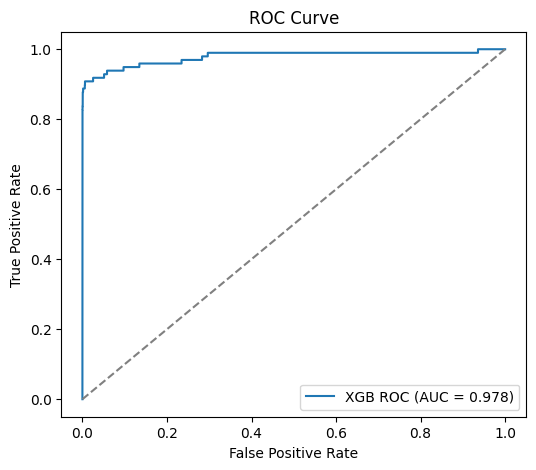

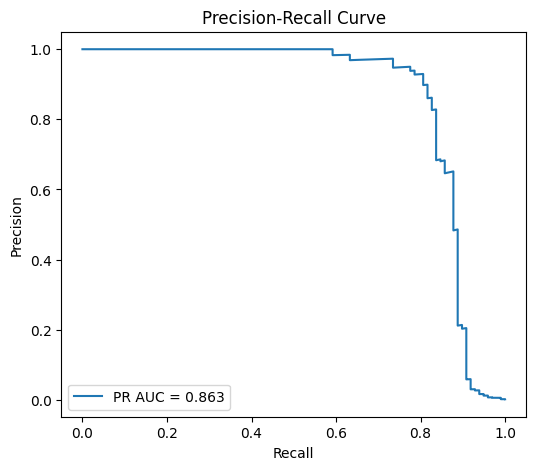

In [41]:
# 03_EVALUATION... - Cell 2
fpr, tpr, _ = roc_curve(y_test, y_proba_xgb)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"XGB ROC (AUC = {roc_auc:.3f})")
plt.plot([0,1],[0,1],'--', color='grey')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.savefig("plots/roc_curve.png", bbox_inches='tight')
plt.show()

# Precision-Recall
precision, recall, _ = precision_recall_curve(y_test, y_proba_xgb)
pr_auc = auc(recall, precision)
plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f"PR AUC = {pr_auc:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.savefig("plots/precision_recall_curve.png", bbox_inches='tight')
plt.show()


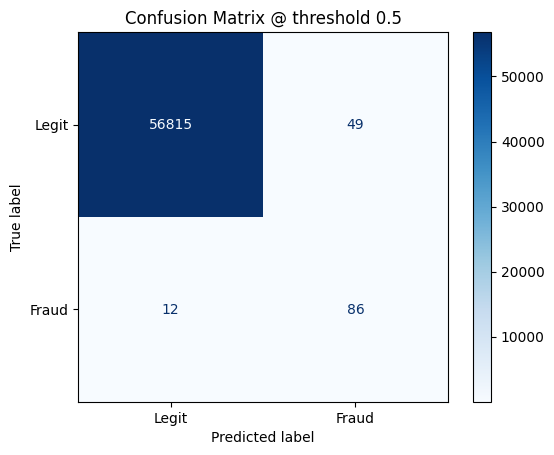

In [14]:
# 03_EVALUATION... - Cell 3
from sklearn.metrics import ConfusionMatrixDisplay

y_pred_default = (y_proba_xgb >= 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred_default)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Legit","Fraud"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix @ threshold 0.5")
plt.savefig("plots/confusion_matrix_default.png", bbox_inches='tight')
plt.show()


Best F1: 0.8586956521739131 at threshold 0.96


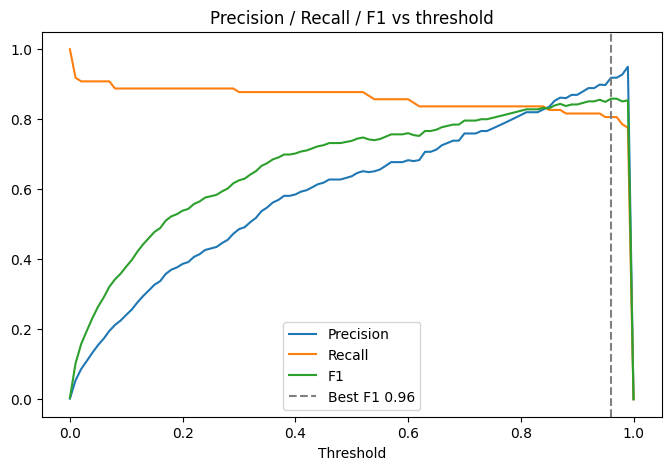

In [15]:
# 03_EVALUATION... - Cell 4
from sklearn.metrics import f1_score, precision_score, recall_score

thresholds = np.linspace(0,1,101)
f1s = []
precisions = []
recalls = []

for t in thresholds:
    preds = (y_proba_xgb >= t).astype(int)
    f1s.append(f1_score(y_test, preds, zero_division=0))
    precisions.append(precision_score(y_test, preds, zero_division=0))
    recalls.append(recall_score(y_test, preds, zero_division=0))

best_idx = np.argmax(f1s)
best_t = thresholds[best_idx]
print("Best F1:", f1s[best_idx], "at threshold", best_t)

plt.figure(figsize=(8,5))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1s, label='F1')
plt.axvline(best_t, color='gray', linestyle='--', label=f'Best F1 {best_t:.2f}')
plt.xlabel("Threshold")
plt.legend()
plt.title("Precision / Recall / F1 vs threshold")
plt.savefig("plots/precision_recall_thresholds.png", bbox_inches='tight')
plt.show()


Min cost threshold: 0.29 with cost: 11970


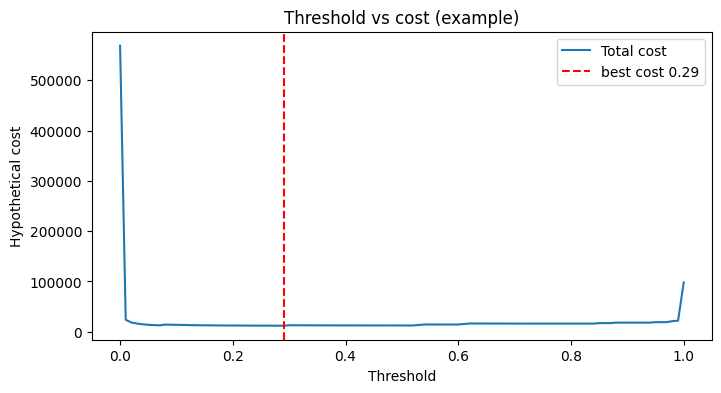

In [16]:
# 03_EVALUATION... - Cell 5
# Define hypothetical costs
C_FN = 1000  # cost of missing a fraud (example)
C_FP = 10    # cost of incorrectly flagging a legit txn

costs = []
for t in thresholds:
    preds = (y_proba_xgb >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    total_cost = fn * C_FN + fp * C_FP
    costs.append(total_cost)

best_cost_threshold = thresholds[np.argmin(costs)]
print("Min cost threshold:", best_cost_threshold, "with cost:", np.min(costs))

plt.figure(figsize=(8,4))
plt.plot(thresholds, costs, label="Total cost")
plt.axvline(best_cost_threshold, color='red', linestyle='--', label=f"best cost {best_cost_threshold:.2f}")
plt.xlabel("Threshold")
plt.ylabel("Hypothetical cost")
plt.legend()
plt.title("Threshold vs cost (example)")
plt.savefig("plots/threshold_cost.png", bbox_inches='tight')
plt.show()


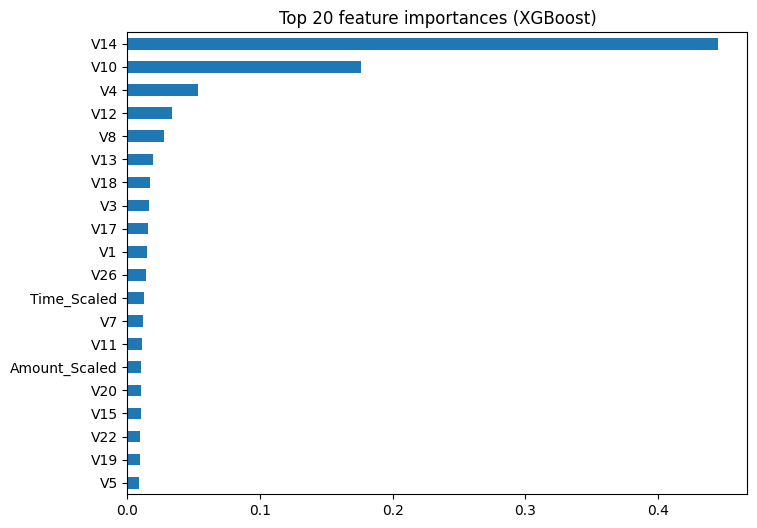

In [19]:
# 03_EVALUATION... - Cell 6
feat_imp = pd.Series(model.feature_importances_, index=X_test_proc.columns).sort_values(ascending=False)

plt.figure(figsize=(8,6))
feat_imp.head(20).plot(kind='barh')
plt.gca().invert_yaxis()
plt.title("Top 20 feature importances (XGBoost)")
plt.savefig("plots/feature_importances.png", bbox_inches='tight')
plt.show()



/var/folders/cs/znlvnwd10tq68l8jbcdgj2vr0000gn/T/ipykernel_98463/2130162833.py:9: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_shap)   # opens in Jupyter (matplotlib)


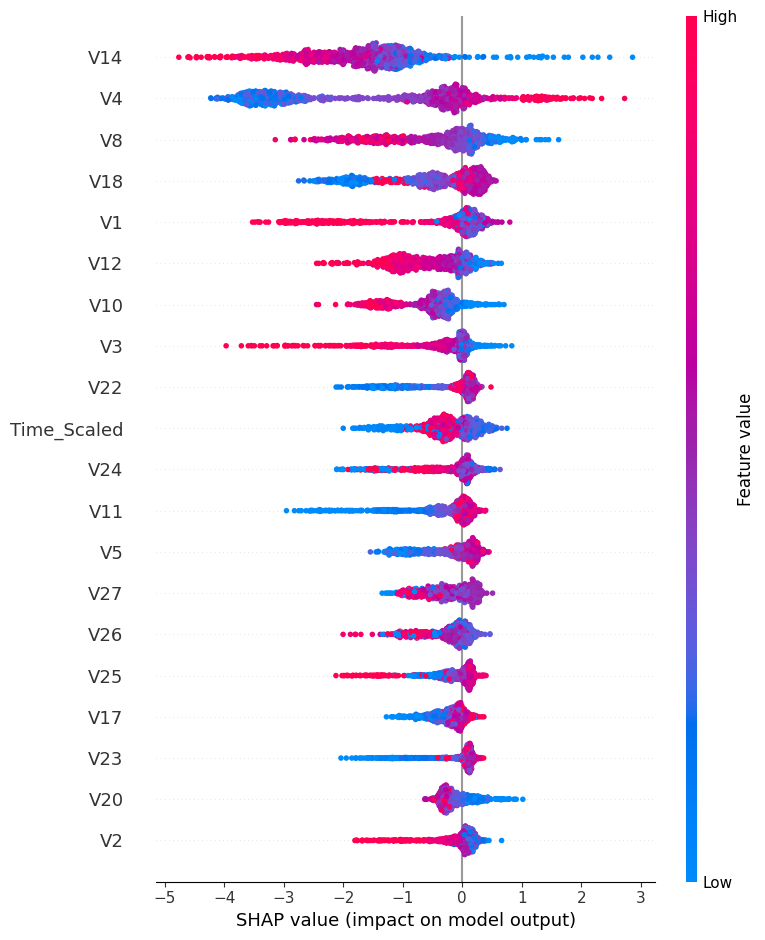

In [42]:
# 03_EVALUATION... - Cell 7
# Only run if shap installed and you have enough memory. Use a subset to keep it fast.
import shap

explainer = shap.TreeExplainer(model)
X_shap = X_test_proc.sample(n=1000, random_state=RANDOM_STATE)
shap_values = explainer.shap_values(X_shap)

shap.summary_plot(shap_values, X_shap)   # opens in Jupyter (matplotlib)
# save as file by using shap.plots._waterfall.waterfall_legacy for specific instances if needed


In [45]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from xgboost import XGBClassifier

RANDOM_STATE = 42

pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=RANDOM_STATE)),
    ('clf', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RANDOM_STATE))
])

param_dist = {
    'clf__n_estimators': [100, 200, 400],
    'clf__max_depth': [3, 6, 8],
    'clf__learning_rate': [0.01, 0.05, 0.1],
    'clf__subsample': [0.6, 0.8, 1.0]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

rs = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=10,
    scoring='average_precision',
    cv=cv,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=1
)

# NOTE: This will take time. Run if you have compute/time.
#rs.fit(x_train_proc, y_train)
#print("Best params:", rs.best_params_)
#print("Best score (AP):", rs.best_score_)


In [43]:
# 03_EVALUATION... - Cell 9
import joblib

# Save the trained XGB (from earlier) and our scaler (we used StandardScaler earlier)
joblib.dump(model, "models/xgb_fraud_model.joblib")
joblib.dump(scaler, "models/amount_time_scaler.joblib")

# Save the chosen threshold
best_threshold = best_cost_threshold  # or best_t from F1
joblib.dump(best_threshold, "models/decision_threshold.joblib")

print("Saved model, scaler, threshold.")


Saved model, scaler, threshold.


In [51]:
# Make sure results folder exists
os.makedirs("results", exist_ok=True)

# Load trained model and scaler
model = joblib.load("models/xgb_fraud_model.joblib")
scaler = joblib.load("models/amount_time_scaler.joblib")

# Columns your model expects (X_test_proc columns)
feature_cols = list(pd.read_csv("data/X_test_proc.csv").columns)

# Generate dummy new transactions (5 rows for testing)
dummy_new = pd.DataFrame(np.random.rand(5, len(feature_cols)), columns=feature_cols)

# If your model expects Amount and Time to be scaled, reverse-engineer them if needed
# Here we assume Amount and Time exist in dummy_new as raw values
if 'Amount' in dummy_new.columns and 'Time' in dummy_new.columns:
    scaled = scaler.transform(dummy_new[['Amount','Time']])
    dummy_new['Amount_Scaled'] = scaled[:,0]
    dummy_new['Time_Scaled'] = scaled[:,1]
    dummy_new = dummy_new.drop(['Amount','Time'], axis=1)

# Predict fraud probability and class
probs = model.predict_proba(dummy_new)[:,1]

# Use 0.5 threshold as default if you didn’t compute a custom one
threshold = 0.5
preds = (probs >= threshold).astype(int)

# Save results
out = dummy_new.copy()
out['fraud_prob'] = probs
out['predicted_class'] = preds

out.to_csv("results/new_predictions.csv", index=False)
print("✅ Dummy predictions saved to results/new_predictions.csv")
out.head()


✅ Dummy predictions saved to results/new_predictions.csv


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V23,V24,V25,V26,V27,V28,Amount_Scaled,Time_Scaled,fraud_prob,predicted_class
0,0.878239,0.788573,0.308315,0.049404,0.051868,0.297120,0.147507,0.873332,0.420783,0.348026,...,0.800423,0.260289,0.430378,0.100590,0.903471,0.069296,0.018242,0.496433,0.000337,0
1,0.603129,0.223214,0.570549,0.895562,0.626115,0.455741,0.144429,0.168942,0.484355,0.463121,...,0.475133,0.421240,0.855166,0.124266,0.793181,0.655330,0.348320,0.919102,0.000073,0
2,0.176946,0.310288,0.374841,0.647796,0.946411,0.593448,0.856306,0.904973,0.466464,0.472434,...,0.434415,0.522449,0.469917,0.776014,0.160962,0.794899,0.741663,0.900822,0.000104,0
3,0.373455,0.176543,0.758629,0.588431,0.712492,0.996740,0.194540,0.411052,0.192697,0.860623,...,0.912888,0.250105,0.447997,0.310321,0.466187,0.696462,0.482064,0.834536,0.000097,0
4,0.553258,0.385765,0.782321,0.431324,0.515553,0.994670,0.786432,0.855142,0.592851,0.348216,...,0.574932,0.108675,0.674805,0.482941,0.502331,0.185822,0.041283,0.611270,0.000074,0


In [52]:
os.makedirs("results", exist_ok=True)

# Load test set
X_test_proc = pd.read_csv("data/X_test_proc.csv")
y_test = pd.read_csv("data/y_test.csv").values.ravel()

# Load model and scaler
model = joblib.load("models/xgb_fraud_model.joblib")
scaler = joblib.load("models/amount_time_scaler.joblib")

# (Optional) if Amount/Time need scaling, already done in X_test_proc

# Predict
probs = model.predict_proba(X_test_proc)[:,1]
threshold = 0.5
preds = (probs >= threshold).astype(int)

# Save results
results = X_test_proc.copy()
results['fraud_prob'] = probs
results['predicted_class'] = preds
results.to_csv("results/original_test_predictions.csv", index=False)

print("✅ Original test set predictions saved to results/original_test_predictions.csv")
results.head()


✅ Original test set predictions saved to results/original_test_predictions.csv


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V23,V24,V25,V26,V27,V28,Amount_Scaled,Time_Scaled,fraud_prob,predicted_class
0,-0.674466,1.408105,-1.110622,-1.328366,1.388996,-1.308439,1.885879,-0.614233,0.311652,0.650757,...,-0.224327,0.707899,-0.135837,0.045102,0.533837,0.291319,-0.259954,1.387182,0.000028,0
1,-2.829816,-2.765149,2.537793,-1.074580,2.842559,-2.153536,-1.795519,-0.250020,3.073504,-1.000418,...,-0.813272,0.042996,-0.027660,-0.910247,0.110802,-0.511938,-0.304426,-1.580138,0.000003,0
2,-3.576495,2.318422,1.306985,3.263665,1.127818,2.865246,1.444125,-0.718922,1.874046,7.398491,...,-0.132058,-1.483996,-0.296011,0.062823,0.552411,0.509764,-0.048286,-0.138120,0.000123,0
3,2.060386,-0.015382,-1.082544,0.386019,-0.024331,-1.074935,0.207792,-0.338140,0.455091,0.047859,...,0.331818,-0.067584,-0.283675,0.203529,-0.063621,-0.060077,-0.347741,0.986536,0.000001,0
4,1.209965,1.384303,-1.343531,1.763636,0.662351,-2.113384,0.854039,-0.475963,-0.629658,-1.579654,...,-0.154631,0.619449,0.818998,-0.330525,0.046884,0.104527,-0.345707,-1.182272,0.000176,0
